In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Python 3.4 버전부터 표준 라이브러리에 포함된 모듈로, 객체 지향적인 방법으로 파일시스템 경로를 다루는 데 사용
from pathlib import Path

# xml 확장자로 저장할 수 있는 텍스트 기반 문서를 의미함. yolov5부터 txt 파일로 yolo의 박스를 인식 못해서
# xml확장자를 써야 한다.
#if 내가 txt 형태로 박스를 분류했다고 하면 roboflow에 가서 txt파일을 xml형식으로 바꾸어 주는 방법이 있다.
#parse함수란 XML 파일을 파싱하여 DOM 객체를 반환한다. 
#좀 더 쉽게 설명하면 XML 파일은 기본적으로 계층적인 구조를 가지는데, 이를 트리 구조로 가지고 온다고 생각하면 편함
from xml.dom.minidom import parse

from shutil import copyfile
#copyfile 함수는 한 파일의 내용을 다른 파일로 복사하는 역할

import os
#경로에 대한 파이썬 라이브러리

아래는 xml 파일을 파싱해서 다음과 같은 DOM 트리를 만든 모습이다.

이렇게 트리화를 가지고 온다고 이해하면 편함.

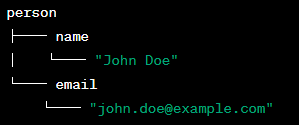

https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection

파일을 다운 받고 구글 드라이브에 zip파일 그대로(난 파일명을 yolo_v8_data으로 변경) 집어 넣기.

레퍼런스 출처 : https://www.kaggle.com/code/princep/helmet-detection-with-yolov8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/yolo_v8_data.zip"

In [ ]:
#이건 리눅스 명령어임. 경로에 dataset파일을 생성하고 하위 경로로
#labels, images 파일을 생성하는 코드
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [ ]:
#객체로 분류하고자 하는 분류
classes = ['helmet','head','person']

한번 xml파일을 txt로 열어보자.

    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>357</xmin>
            <ymin>116</ymin>
            <xmax>404</xmax>
            <ymax>175</ymax>
        </bndbox>

<name>helmet</name> 객체의 이름

        <xmin>357</xmin>
        <ymin>116</ymin>
        <xmax>404</xmax>
        <ymax>175</ymax>

        이건 각 좌표

In [ ]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [ ]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/content/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [ ]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
!ls /content/Dataset/labels

In [ ]:
files = os.listdir('/content/annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('/content/annotations', file_xml[0])

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/content/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [ ]:
train_list[0:5]

['hard_hat_workers527.png',
 'hard_hat_workers2116.png',
 'hard_hat_workers2076.png',
 'hard_hat_workers2999.png',
 'hard_hat_workers4472.png']

In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/content/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/content/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/content/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/content/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, '/content/Dataset/labels', '/content/images', "train")
copy_data(val_list,   '/content/Dataset/labels', '/content/images', "val")
copy_data(test_list,  '/content/Dataset/labels', '/content/images', "test")

Path /content/Dataset/images/train does not exit
Path /content/Dataset/labels/train does not exit
Path /content/Dataset/images/val does not exit
Path /content/Dataset/labels/val does not exit
Path /content/Dataset/images/test does not exit
Path /content/Dataset/labels/test does not exit


In [ ]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 7946, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 7946 (delta 31), reused 40 (delta 25), pack-reused 7887
Receiving objects: 100% (7946/7946), 5.74 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (5359/5359), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 29.2 MB/s eta 0:00:00


In [ ]:
import yaml

# Create configuration
config = {
   "path": "/content/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   #nc는 클래스 갯수
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [ ]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
path: /content/Dataset/images
test: test
train: train
val: val


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c5cc9836d8968f2c5003fda71d3afa605bcb00ef2e2bcb18627b1c2bb1a0590b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb disabled

W&B disabled.


In [ ]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01

100% 21.5M/21.5M [00:00<00:00, 160MB/s]
Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False,

In [ ]:
!ls /content/runs/detect/train

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1683853014.2d750b79ca32.3020.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


In [ ]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

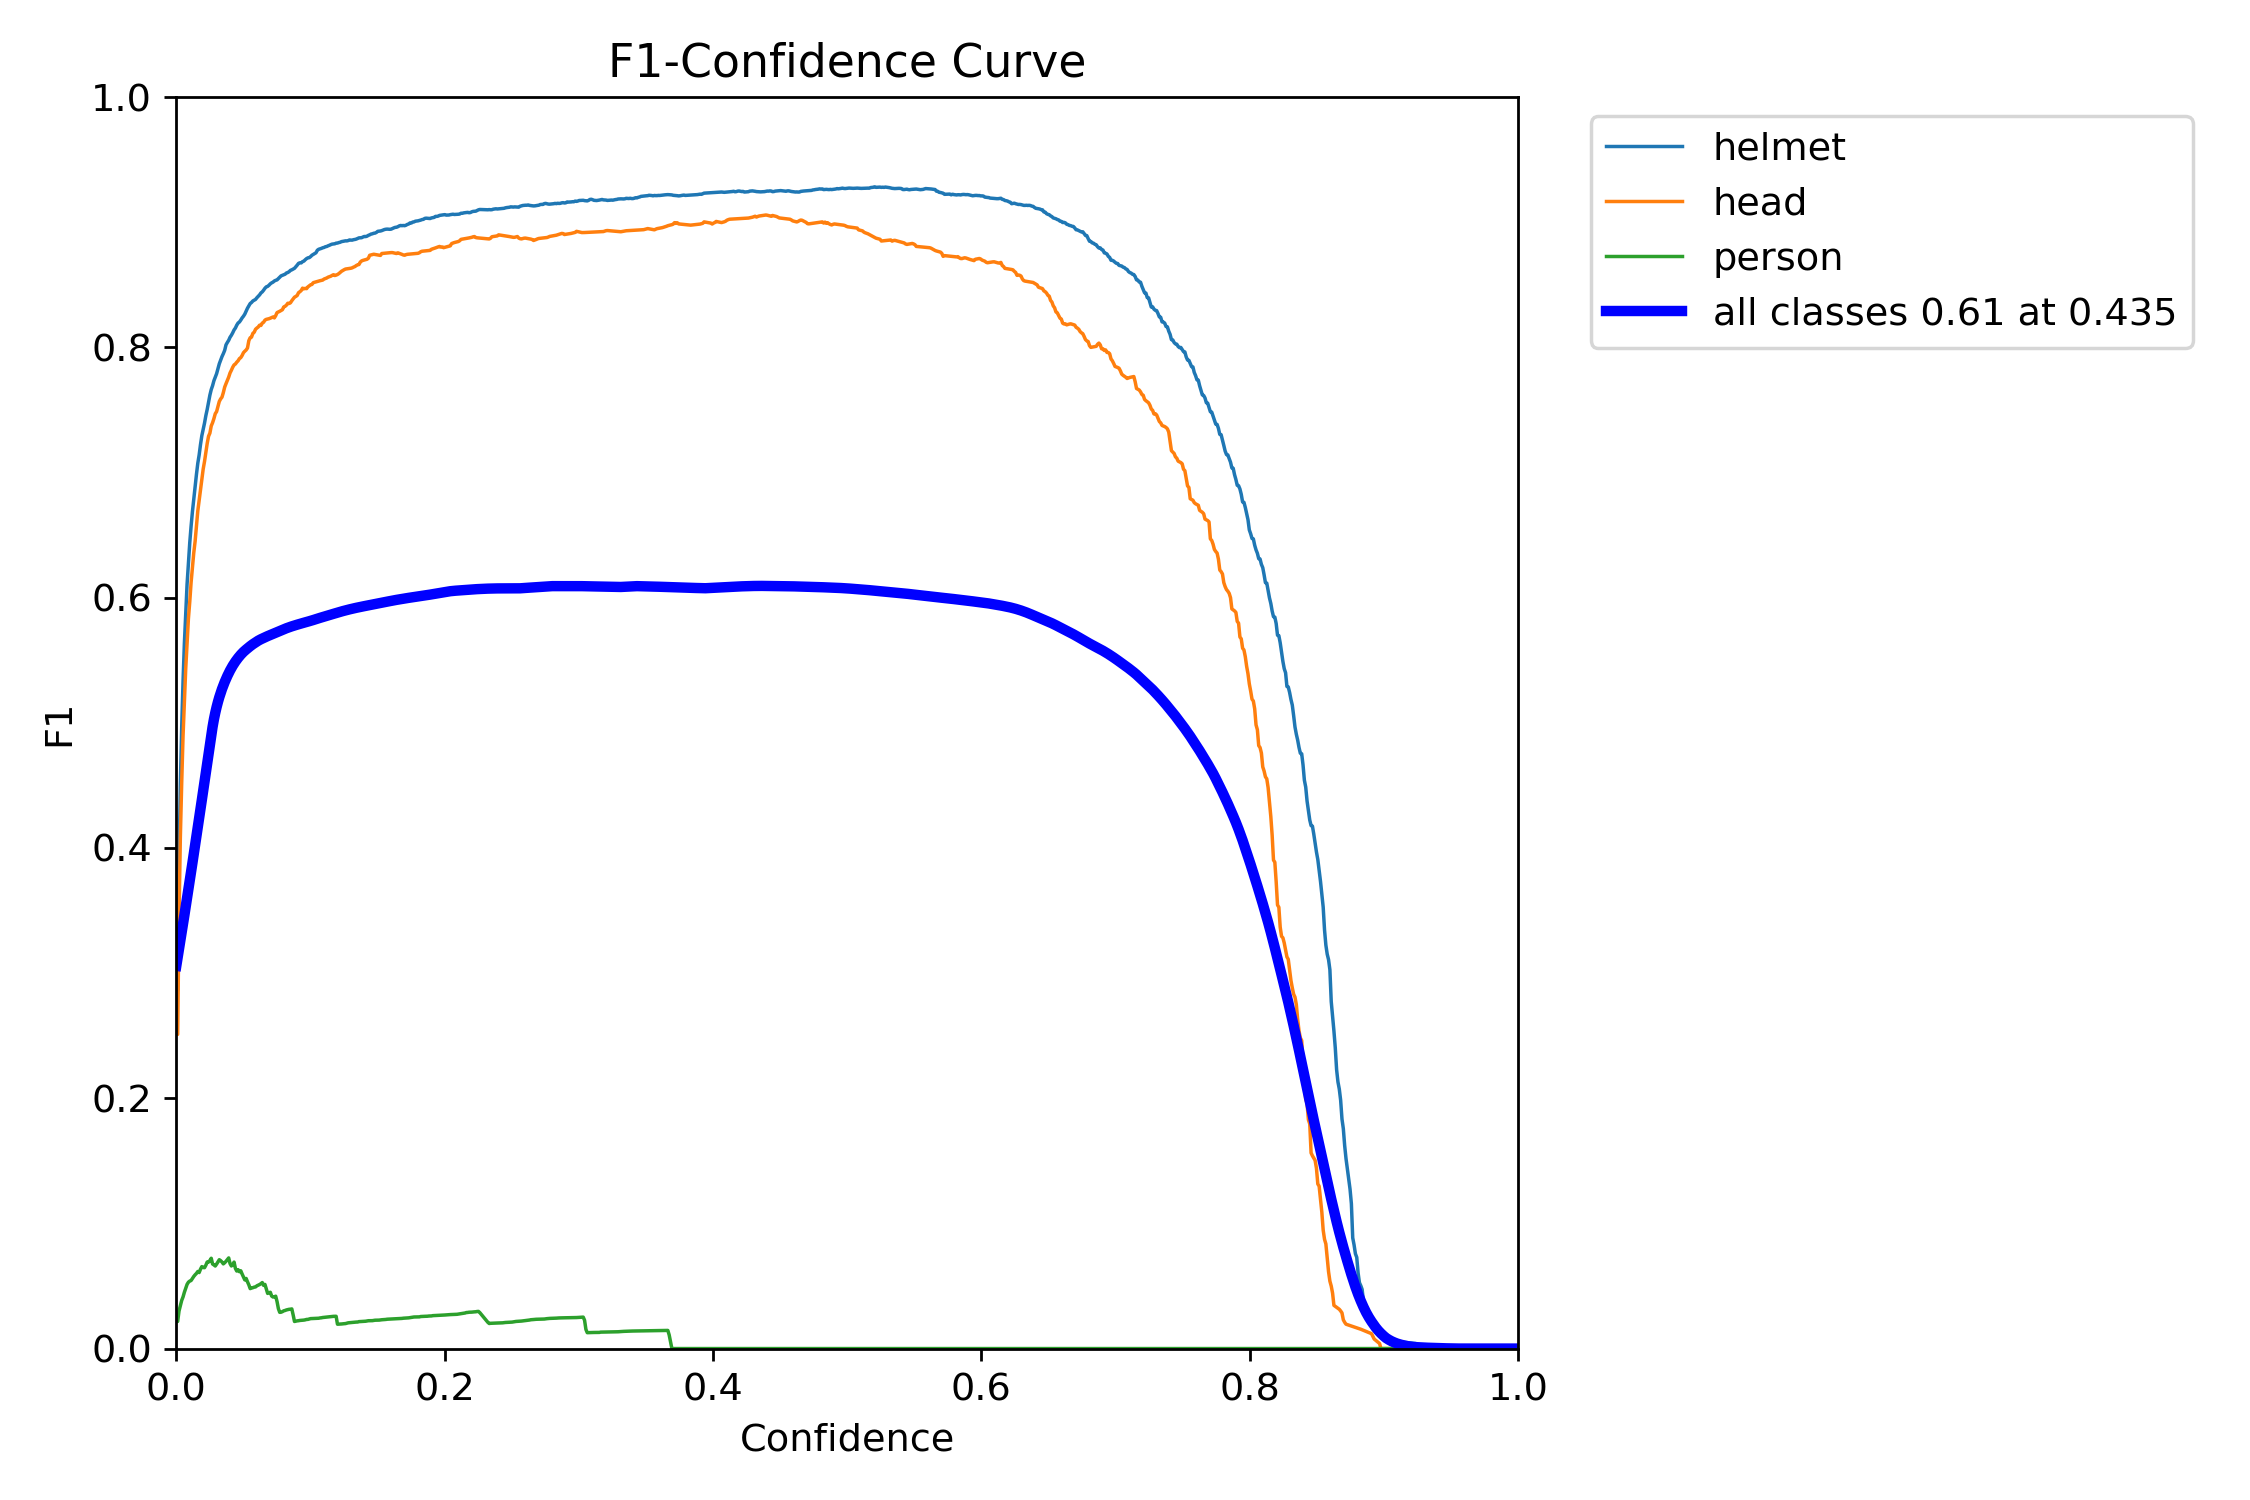

In [ ]:
Image(filename='/content/runs/detect/train/F1_curve.png', width=600)

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/content/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

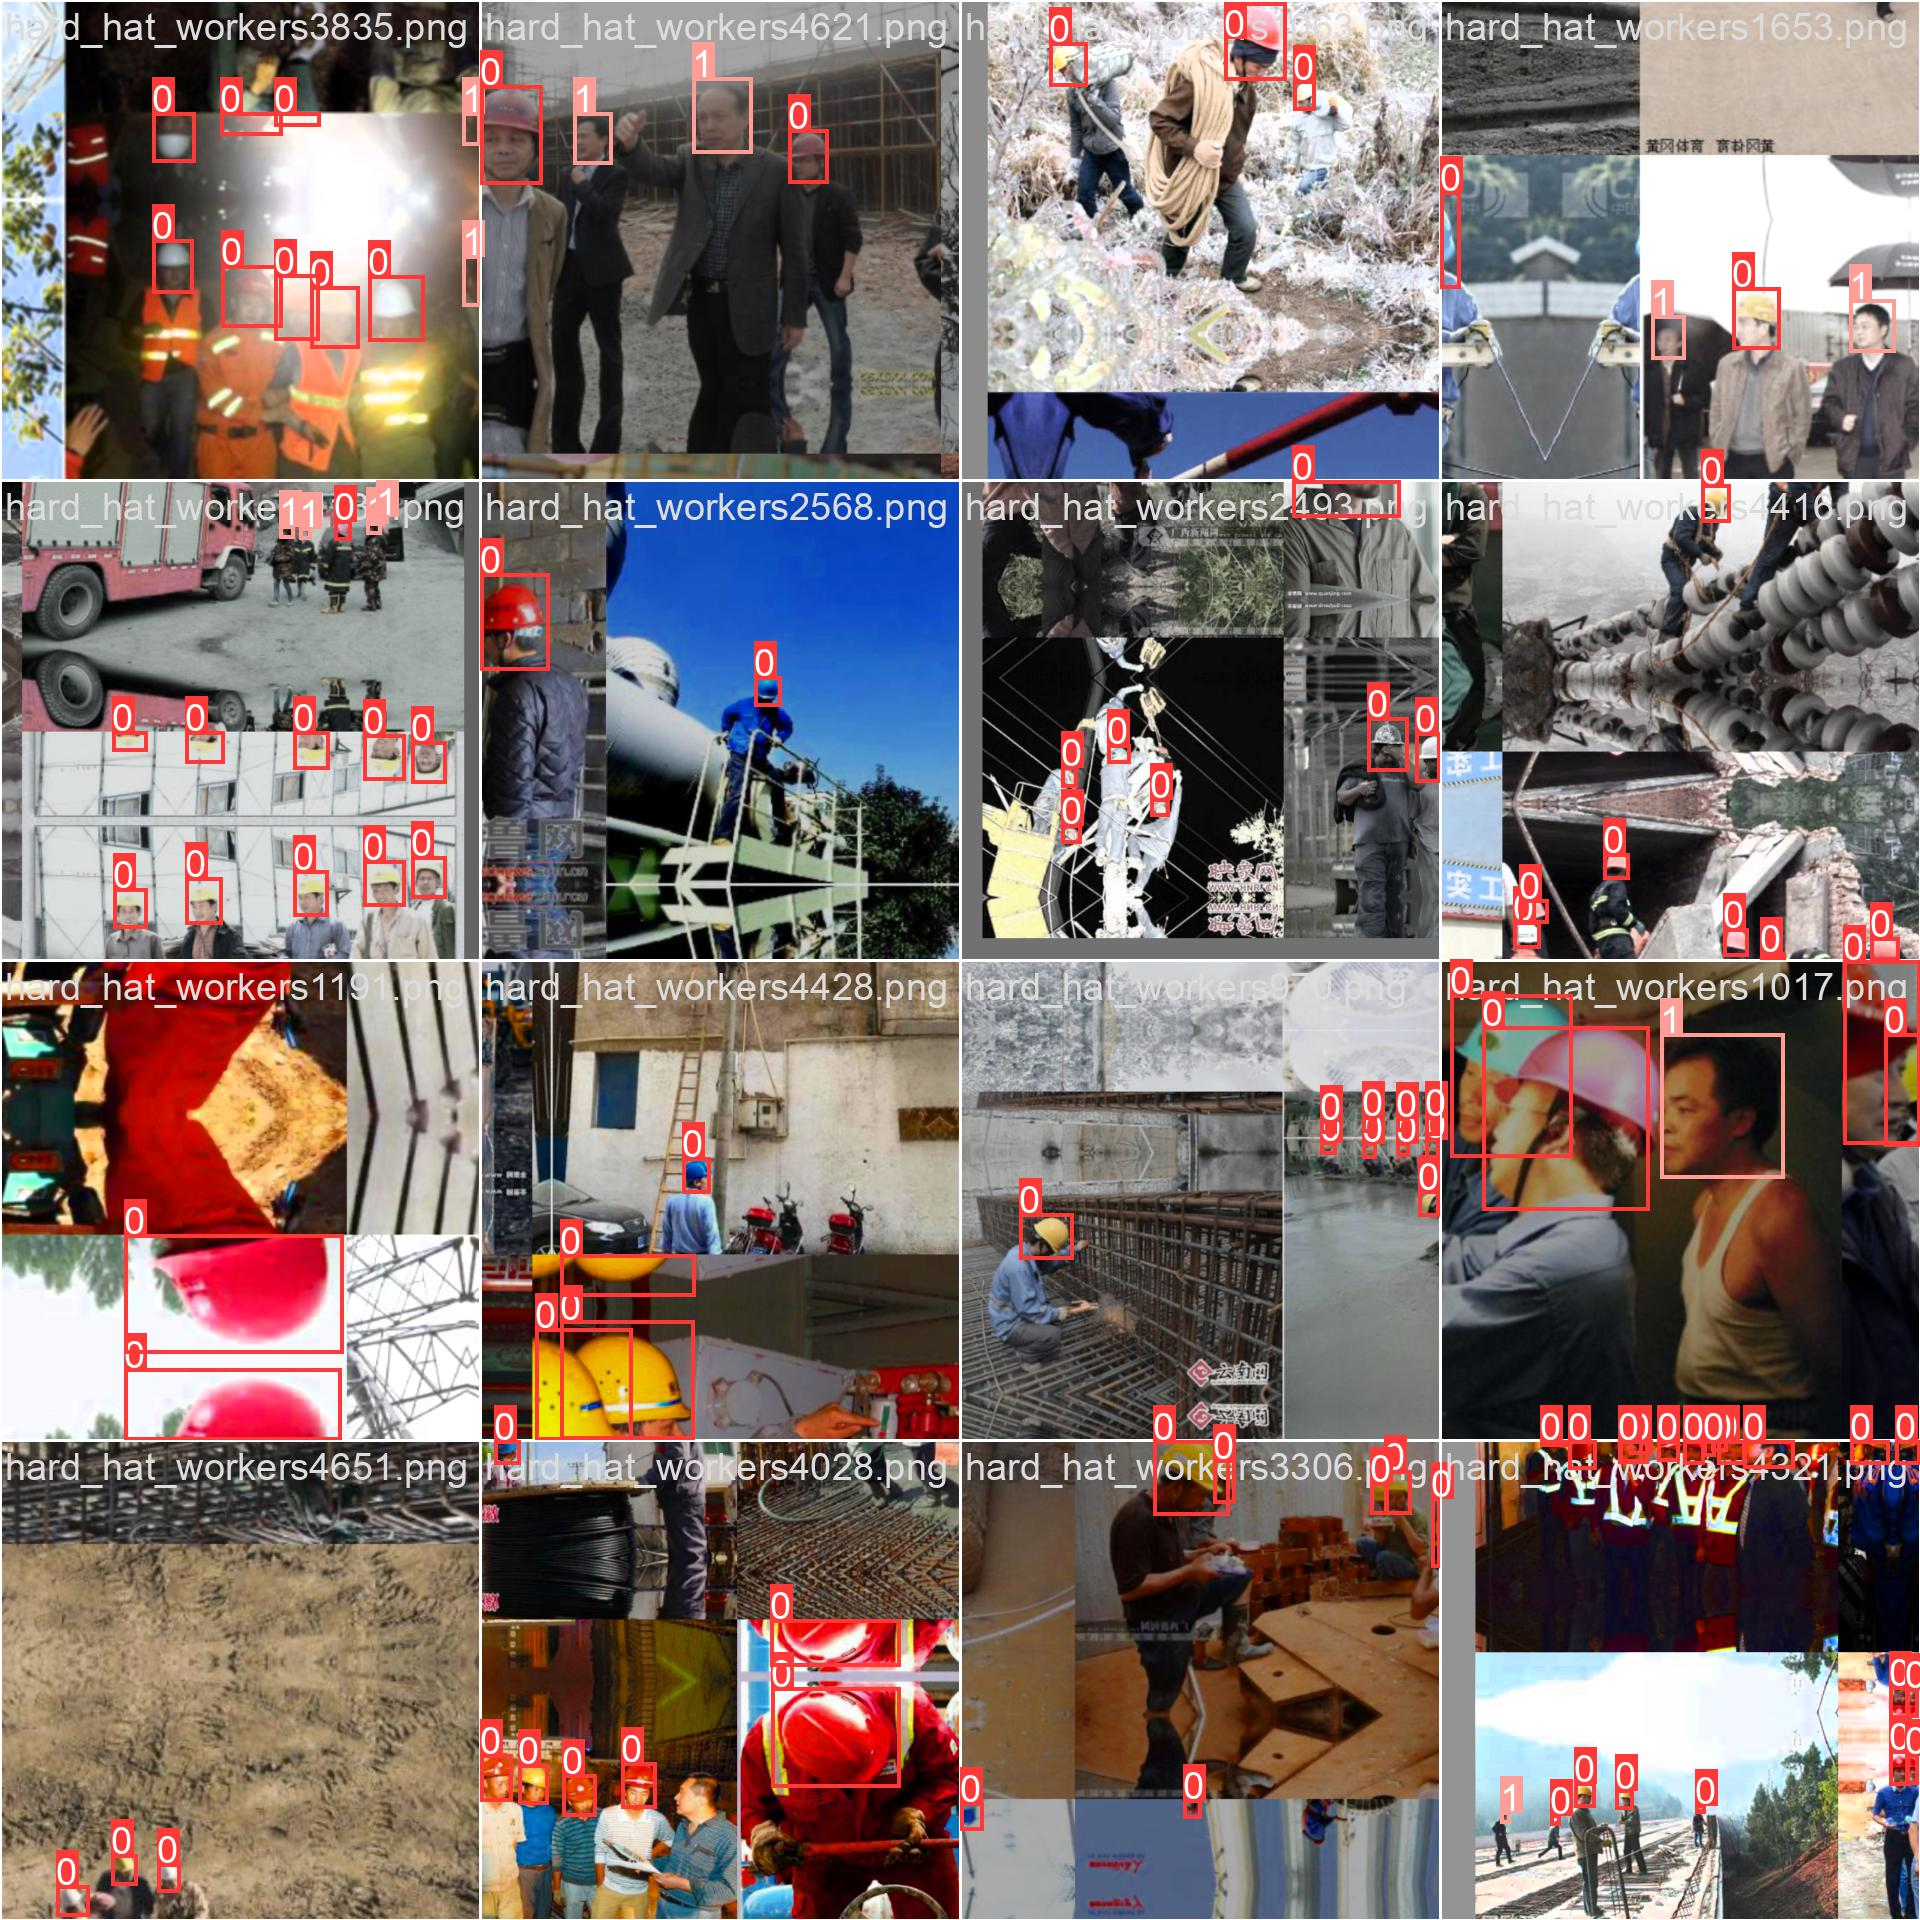

In [ ]:
Image(filename='/content/runs/detect/train/train_batch0.jpg', width=1000)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=data.yaml

Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/Dataset/labels/val.cache... 500 images, 0 backgrounds, 0 corrupt: 100% 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 32/32 [00:14<00:00,  2.13it/s]
                   all        500       2551      0.601      0.616      0.647      0.439
                helmet        500       1957       0.91      0.926      0.965      0.647
                  head        500        506      0.876      0.911      0.949      0.654
                person        500         88     0.0157     0.0114     0.0272     0.0153
Speed: 2.1ms preprocess, 9.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val
